In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from numba import jit

import sys
sys.path.append('..')
from lib import *
from lib.maxent import *
plt.style.use('../peptidome.mplstyle')
import pyrepseq.plotting as prsp

datadir = '/media/andreas/data/Dropbox (Princeton)/data/peptidome/maxent'

In [33]:
k = 9
#datasets = ['train', 'test', 'flat', 'independent', 'nskewfcov']
datasets = ['flat', 'independent', 'nskewfcov']
sample_matrices = {}
for dataset in datasets:
    if dataset == 'flat':
        sample_matrices[dataset] =  load_matrix(f'data/%s_matrix_k9.csv.gz' % dataset)
    elif dataset in ['train', 'test']:
        sample_matrices[dataset] =  load_matrix(f'{datadir}/Human_%s_k9_matrix.csv.gz' % dataset)
    else:
        sample_matrices[dataset] =  load_matrix(f'{datadir}/Humanviruses_%s_k9_matrix.csv.gz' % dataset)

In [25]:
reference = set(count_kmers_proteome(human, k, clean=True))

In [8]:
'%e'%len(reference)

'1.040283e+07'

In [9]:
#reference_traintest = set(matrix_to_kmers(sample_matrices['train'])) | set(matrix_to_kmers(sample_matrices['test']))
#len(reference), len(reference_traintest)

In [26]:
def mat_to_dist(A, size=100000):
    sample = matrix_to_kmers(A[np.random.choice(A.shape[0], size=size, replace=False), :])
    ns = nndist_hamming_distribution(sample, reference)
    return ns

In [27]:
kmers = matrix_to_kmers(load_matrix('data/Humanviruses_train_k9_matrix.csv.gz'))

In [28]:
overlap = [kmer for kmer in kmers if kmer in reference]

In [29]:
len(overlap)/len(kmers), len(kmers)

(0.001632229599030163, 526274)

In [40]:
ns_dict = {}
for model in datasets:
    print(model)
    ns_dict[model] = mat_to_dist(sample_matrices[model])
    print(np.sum(ns_dict[model]), ns_dict[model])

flat
100000 [    1   346 18725 80928]
independent
100000 [    7  1258 43132 55603]
nskewfcov
100000 [   79  2567 47022 50332]


In [41]:
ns_dict['empirical'] = mat_to_dist(load_matrix('data/Humanviruses_train_k9_matrix.csv.gz'))
ns_dict['empirical']

array([  174,  2962, 47686, 49178])

In [42]:
model_to_label = {'flat' : 'Null',
                  'independent' : 'Independent',
                  'nskewfcov' : 'Model',
                  'empirical' : 'Data'}

In [43]:
ps_dict = {key: value/np.sum(value) for key, value in ns_dict.items()}
ps_dict['flat'][0] = len(reference)/20**k

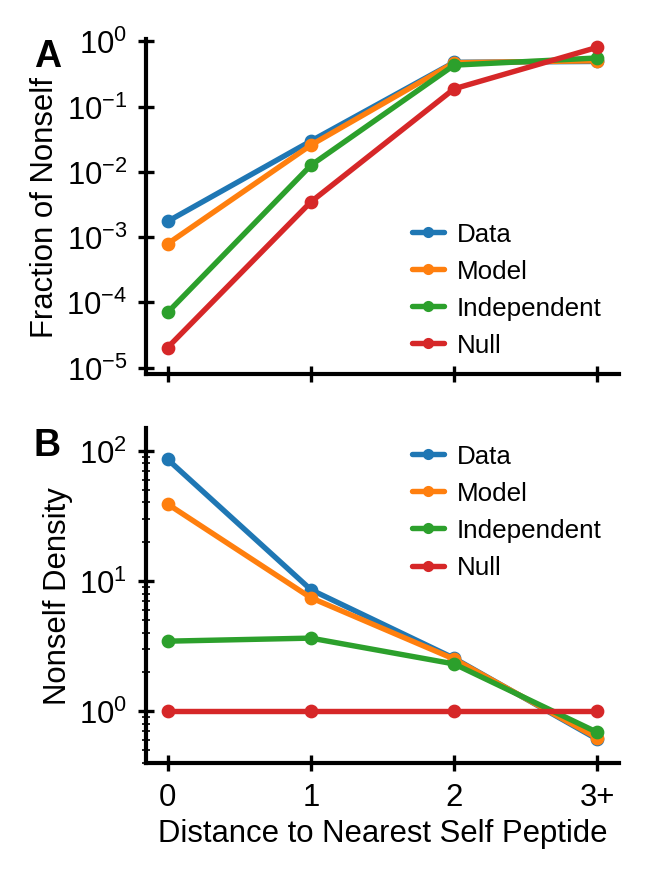

In [48]:
fig, axes = plt.subplots(figsize=(2.25, 3.0), nrows=2, sharex=True)
ps_flat = ps_dict['flat']
for model in ['empirical', 'nskewfcov','independent', 'flat']:
    ps = ps_dict[model]
    axes[0].plot(range(4), ps, '-o', label=model_to_label[model])
    axes[1].plot(range(4), ps/ps_flat, '-o', label=model_to_label[model])

for ax in axes:
    ax.set_yscale('log')
    ax.set_xticks([0, 1, 2, 3])
    ax.set_xticklabels([0, 1, 2, '3+'])

axes[0].set_ylim(8e-6, 1.1)
axes[0].set_yticks(10**np.arange(-5.0, 1.0, 1.0))
axes[1].set_yticks([1e0, 1e1, 1e2])
axes[1].set_ylim(4e-1, 1.5e2)

axes[0].set_ylabel('Fraction of Nonself')
axes[0].legend(loc='lower right')
axes[1].set_ylabel('Nonself Density')
axes[1].legend(loc='upper right')

axes[1].set_xlabel('Distance to Nearest Self Peptide')
prsp.label_axes(fig, xy=(-0.18, 1.0), va='top', ha='right')
fig.tight_layout()
fig.savefig('distances.pdf')
fig.savefig(figuredir+'neighbors.svg')

In [45]:
ps = ps_dict['empirical']
density = ps/ps_flat
density/density[-1]

array([140.92741502,  14.08759639,   4.19080075,   1.        ])